Comparing how agent motion differs between 2D and 3D flocking. The key challenge is making a fair comparison: in 3D, agents have an extra dimension to move in, which changes the expected number of neighbors if we keep the same interaction radius.

We solve this by adjusting the 3D interaction radius so both models have the same average neighbor count. Then we measure diffusivity (how much agents wander around) to see if dimensionality affects individual motion patterns beyond just changing the number of neighbors.

In [ ]:
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from src.flocking_sim import run_simulation as run_sim_2d
from src.flocking_sim_3d import run_simulation as run_sim_3d

PROJECT_ROOT = Path.cwd().parent
sys.path.insert(0, str(PROJECT_ROOT))
print("Import from", PROJECT_ROOT)

In [ ]:
# default parameters for both 2D and 3D
N=200
steps=400
box_size=1.0
align=1.0
cohesion=0.5              
noise=0.05
R=0.15
speed=0.03
repulsion_radius=0.05
repulsion_strength=1.0
dt=0.1
seed=None
save_every=1


Matching neighbor counts between dimensions. In 2D, the interaction region is a circle with area πR². In 3D, it's a sphere with volume (4/3)πR³. For the same expected neighbor count, we need (density_2D × πR₂²) = (density_3D × (4/3)πR₃³). Solving for R₃ gives us the adjusted radius.

In practice, density isn't uniform because flocks cluster. So we compute empirical neighbor counts after burn-in and iteratively adjust R₃ until the average matches the 2D model.

In [ ]:
def expected_k(N, box_size, R, dim):
    """
    Calculates the expected average number of neighbors per agent a given
    N -> Flock size
    box_size
    R -> Interaction radius
    dim -> dimension
    """
    density = N / (box_size ** dim)
    if dim == 2: 
        vol = np.pi * R**2              # interaction radius is a cricle
    elif dim == 3:
        vol = (4/3) * np.pi * R**3      # interaction radius is a sphere
    else:
        raise ValueError("dim must be 2 or 3")
    return density * vol


def R3_to_match_k2(N, box_size_2d, R2, box_size_3d=None):
    """
    Calculates an interation radius for the 3D model, R3, such that the 3D mdoel's expected neighbour
    is the same as the 2D model
    
    N: flock size
    box_size_2d: 2D box side
    R2: 2D interaction radius
    box_size_3d: 3D box side length (optional)
    """

    if box_size_3d is None:
        box_size_3d = box_size_2d
    k2 = expected_k(N, box_size_2d, R2, dim=2) # computes expected neighbour from 2D model
    rho3 = N / (box_size_3d ** 3) # compute 3D density
    R3 = (k2 / (rho3 * (4/3) * np.pi)) ** (1/3) # compute matching radius
    return R3, k2

In [25]:
# 1) show mismatch if you keep R the same in 3D
k2 = expected_k(N, box_size, R, dim=2)
k3_sameR = expected_k(N, box_size, R, dim=3)

print("If you keep the SAME R in 3D:")
print("k̄2D =", k2)
print("k̄3D =", k3_sameR)

# 2) compute the R3 that matches the 2D expected neighbor count
R3, k_target = R3_to_match_k2(N, box_size, R, box_size_3d=box_size)

# verify it actually matches in theory
k3_matched = expected_k(N, box_size, R, dim=3)

print("\nRadius needed to match neighbor count:")
print("R3 =", R3)
print("k̄ target =", k_target)
print("k̄3D (with R3) =", k3_matched)

If you keep the SAME R in 3D:
k̄2D = 14.137166941154069
k̄3D = 2.8274333882308134

Radius needed to match neighbor count:
R3 = 0.2564963920015046
k̄ target = 14.137166941154069
k̄3D (with R3) = 2.8274333882308134


The theoretical radius assumes uniform density, but flocks cluster dynamically. So we measure empirical neighbor counts after burn-in and iteratively search for the R₃ that matches the 2D model's observed average.

In [ ]:

def mean_neighbor_count_snapshot(pos, R, L):
    """
    Computes the average number of neighbors per agent in a single snapshot, 
    counting agents within radius R under periodic boundary conditions in a box of size L.
    
    """
    
    diffs = pos[:, None, :] - pos[None, :, :] # Builds all pairwise displacement vectors between agents
    diffs -= L * np.round(diffs / L)       # adjust for periodic boundary conditions
    dists = np.linalg.norm(diffs, axis=-1) # Converts each displacement vector into a scalar distance for every pair
    neigh = (dists < R) & (dists > 0) # Mark which pairs are close enough to count as neighbors
    return neigh.sum(axis=1).mean()

def late_mean_neighbor_count(positions, R, L, burn_frac=0.5):
    """Computes the average neighbor count using only the later part of the simulation"""
    # positions: (T, N, dim)
    T = positions.shape[0]
    burn = int(burn_frac * T)
    ks = [mean_neighbor_count_snapshot(positions[t], R, L) for t in range(burn, T)] # compute the average neighbors for each time step
    return float(np.mean(ks)) # Take the average of those late neighbor counts

def find_R3_match_empirical_k(
    pos2_saved, # saved 2D positions
    R2, 
    L,
    run_simulation_3d, 
    sim_kwargs_3d,
    burn_frac=0.5, # Fraction of the beginning of the simulation to ignore
    tol=0.05, # How close the 3D neighbor count must be to the 2D target before we stop
    max_iter=15, # Maximum number of search steps
    R3_init=None, # Starting guess for the 3D radius; if None, it defaults to R2.
    seed=0,
    verbose=True,
):
    """
    Automatically searches for the 3D interaction radius R3 that makes 3D agents
    have the same average number of neighbors as in 2D
    """
    # 2D target (from your actual 2D run)
    k_target = late_mean_neighbor_count(pos2_saved, R2, L, burn_frac=burn_frac)
    if verbose:
        print(f"k_target (2D late) = {k_target:.3f}")

    # helper: run 3D at a radius and return late-time k
    def k3_late(R3): # Helper that tells us “if we pick this R3, how many neighbors do we get in 3D?”
        pos3_saved = run_simulation_3d(R=R3, seed=seed, **sim_kwargs_3d)
        return late_mean_neighbor_count(pos3_saved, R3, L, burn_frac=burn_frac)

    # start guess
    if R3_init is None:
        R3_init = R2

    # bracket: find low/high such that k(low) < target < k(high)
    R_low = max(1e-4, 0.5 * R3_init)
    R_high = 2.0 * R3_init

    k_low = k3_late(R_low)
    k_high = k3_late(R_high)

    grow = 0
    while k_high < k_target and grow < 20:
        R_high *= 1.3
        k_high = k3_late(R_high)
        grow += 1

    shrink = 0
    while k_low > k_target and shrink < 20:
        R_low *= 0.7
        k_low = k3_late(R_low)
        shrink += 1

    if verbose:
        print(f"Bracket: R_low={R_low:.6f} (k={k_low:.3f}), R_high={R_high:.6f} (k={k_high:.3f})")

    # binary search
    best = None
    for it in range(max_iter):
        R_mid = 0.5 * (R_low + R_high)
        k_mid = k3_late(R_mid)
        diff = k_mid - k_target

        best = (R_mid, k_mid, diff)

        if verbose:
            print(f"iter {it:02d}: R3={R_mid:.6f}, k3={k_mid:.3f}, diff={diff:+.3f}")

        if abs(diff) <= tol:
            break

        if k_mid < k_target:
            R_low = R_mid
        else:
            R_high = R_mid

    R3_final, k3_final, diff_final = best
    return R3_final, k_target, k3_final



In [42]:
# pos2_saved is your 2D output (T,N,2)
# R2 is your 2D radius
# run_simulation_3d is your 3D sim function

sim_kwargs_3d = dict(
    N=N,
    steps=steps,
    box_size=L,
    align=align,
    cohesion=cohesion,
    noise=noise,
    speed=speed,
    repulsion_radius=repulsion_radius,
    repulsion_strength=repulsion_strength,
    dt=dt,
    save_every=save_every,
)

R3_emp, k_target, k3_emp = find_R3_match_empirical_k(
    pos2_saved=pos_2d,
    R2=R2,
    L=box_size,
    run_simulation_3d=run_simulation_3d,
    sim_kwargs_3d=sim_kwargs_3d,
    burn_frac=0.5,
    tol=0.05,
    max_iter=10,
    seed=0,
    verbose=True,
)

print("\nEmpirical match result:")
print("R3_emp =", R3_emp)
print("k_target (2D late) =", k_target)
print("k3_emp (3D late)   =", k3_emp)


k_target (2D late) = 13.774
Bracket: R_low=0.075000 (k=0.485), R_high=0.300000 (k=24.847)
iter 00: R3=0.187500, k3=6.948, diff=-6.826
iter 01: R3=0.243750, k3=14.515, diff=+0.740
iter 02: R3=0.215625, k3=10.332, diff=-3.442
iter 03: R3=0.229687, k3=12.326, diff=-1.449
iter 04: R3=0.236719, k3=13.383, diff=-0.392
iter 05: R3=0.240234, k3=13.932, diff=+0.157
iter 06: R3=0.238477, k3=13.647, diff=-0.128
iter 07: R3=0.239355, k3=13.790, diff=+0.016

Empirical match result:
R3_emp = 0.23935546875
k_target (2D late) = 13.77435
k3_emp (3D late)   = 13.7902


In [43]:
pos_2d = run_simulation_2d(
    N=N,
    steps=steps,
    box_size=box_size,
    align=align,          
    noise=noise,
    R=R,
    speed=speed,
    dt=dt,
    seed=seed,
    save_every=save_every,
)

pos_3d = run_simulation_3d(
    N=N,
    steps=steps,
    box_size=box_size,
    align=align,
    cohesion=cohesion,               
    noise=noise,
    R=R3_emp,
    speed=speed,
    repulsion_radius=repulsion_radius,
    repulsion_strength=repulsion_strength,
    dt=dt,
    seed=seed,
    save_every=save_every,
)



Diffusion is defined as the change of a specific bird's position relative position to the flocks center of mass. In simple terms, diffusion is how much a specific moves within the flock while still following the flocks collective motion. 

We quantify diffusion by looking at the average mean squared displacement (MSD) of a single bird over time.

1. Compute flock's center of mass $R_{CM}(t)$ - averaging the positions of all $N$ agents at each time $t$ to get the flock's overall position

2. Compute relative motion to center of mass - subtract each agents position witht the center of mass position $\Rightarrow$ $r_{i}(t) = R_{i}(t) - R_{CM}(t)$

3. Compute MSD to see how much an agent wandered within the flock - for a chosen time lag $\tau$ we take the difference between agent $i$ intial position and the position after time lag $\tau$ to see how far the agent has moved within the flock $\Rightarrow$ $r_{i}(t_{0} + \tau) - r_{i}(t_{0})$

4. We then square the MSD to get the magnitude of the movement and opposite directions do not cancel each other. $\Rightarrow$ $\left\| r_{i}(t_{0} + \tau) - r_{i}(t_{0}) \right\|^{2}$

5. We then average this squared displacement over all starting times $t_{0}$ so we use the whole time series and over all agents 
$i$ so we capture typical behaviour rather than one noisy path.

In [44]:

def center_of_mass_positions(positions: np.ndarray) -> np.ndarray:
    """
    positions: array of shape (T, N, d)
    returns: R_cm(t) of shape (T, d)
    """
    return positions.mean(axis=1)

def positions_in_com_frame(positions: np.ndarray) -> np.ndarray:
    """
    Convert positions relative to center of mass r_i(t) = R_i(t) - R_cm(t).

    positions: (T, N, d)
    returns:   (T, N, d)
    """
    R_cm = center_of_mass_positions(positions)      
    return positions - R_cm[:, None, :]       

def unwrap_positions_pbc(positions: np.ndarray, box_size: float) -> np.ndarray:
    """
    Unwrap positions for periodic boundary conditions so trajectories are continuous.

    positions: (T, N, d) positions in [0, box_size)
    box_size:  float, size of periodic box
    returns:   (T, N, d) unwrapped positions
    """
    if box_size is None:
        return positions.copy()

    pos = positions.copy()

    # step displacements (T-1, N, d)
    steps = np.diff(pos, axis=0)

    # bring each step into [-box/2, box/2]
    steps -= box_size * np.round(steps / box_size)

    # reconstruct unwrapped positions
    pos_unwrapped = np.empty_like(pos)
    pos_unwrapped[0] = pos[0]
    pos_unwrapped[1:] = pos_unwrapped[0] + np.cumsum(steps, axis=0)
    return pos_unwrapped

def msd_com_frame(
    positions: np.ndarray,
    dt: float = 1.0,
    save_every: int = 1,
    box_size: float | None = None,
    max_lag: int | None = None,
    average_over_agents: bool = True,
    agent_idx: int = 0,
) -> tuple[np.ndarray, np.ndarray]:
    """
    Compute mean-squared displacement (MSD) in the center-of-mass frame, following the paper's idea:
      r_i(t) = R_i(t) - R_CM(t)
      MSD(tau) = average_{t0, i} ||r_i(t0+tau) - r_i(t0)||^2

    positions: (T, N, d)
    dt: simulation timestep
    save_every: how often you saved (1 if you saved every step)
    box_size: periodic box size (None if not periodic)
    max_lag: maximum lag in SAVED steps (None -> T-1)
    average_over_agents: True -> average over all agents i (paper-style)
                         False -> compute MSD for one agent only (agent_idx)
    agent_idx: which agent to use if average_over_agents=False

    returns:
      t_lag: (L,) lag times in the same time units as dt
      msd:   (L,) MSD values
    """

    T, N, d = positions.shape

    # 1) unwrap in lab frame if periodic
    pos_u = unwrap_positions_pbc(positions, box_size) if box_size is not None else positions

    # 2) convert to COM frame
    pos_com = positions_in_com_frame(pos_u)  # (T, N, d)


    # 3) choose max lag
    if max_lag is None:
        max_lag = T - 1
    max_lag = int(max_lag)
    if max_lag < 1 or max_lag > T - 1:
        raise ValueError(f"max_lag must be in [1, {T-1}]")

    taus = np.arange(1, max_lag + 1)  # lag in saved steps
    msd = np.empty_like(taus, dtype=float)

    if average_over_agents:
        # paper-style: average over i and t0
        for k, tau in enumerate(taus):
            disp = pos_com[tau:] - pos_com[:-tau]         
            msd[k] = np.mean(np.sum(disp**2, axis=-1)) 
    else:
        # single-agent MSD (still averaged over t0)
        i = int(agent_idx)
        if i < 0 or i >= N:
            raise ValueError(f"agent_idx must be in [0, {N-1}]")
        traj = pos_com[:, i, :]                       
        for k, tau in enumerate(taus):
            disp = traj[tau:] - traj[:-tau]            
            msd[k] = np.mean(np.sum(disp**2, axis=-1))     

    # convert lag steps -> physical time
    t_lag = taus * dt * save_every
    
    return t_lag, msd



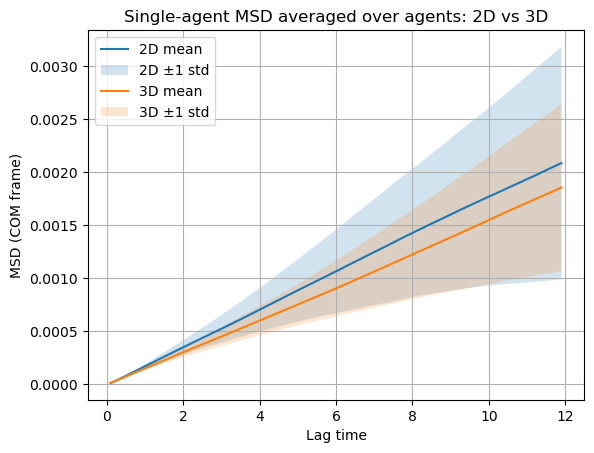

In [47]:
import random

runs = 50
N = pos_2d.shape[1]
T = pos_2d.shape[0]

agent_ids = random.sample(range(N), k=min(runs, N))

msd2_list = []
msd3_list = []

max_lag_cap = max(1, int(0.30 * (T - 1)))

for i in agent_ids:
    
    t2, msd2 = msd_com_frame(
        pos_2d,
        dt=dt,
        save_every=1,              # set to your save_every if not 1
        box_size=box_size,         # set to None if no periodic boundaries
        max_lag=max_lag_cap,
        average_over_agents=False, # single agent
        agent_idx=i
    )

    t3, msd3 = msd_com_frame(
        pos_3d,
        dt=dt,
        save_every=1,
        box_size=box_size,
        max_lag=max_lag_cap,
        average_over_agents=False,
        agent_idx=i
    )

    msd2_list.append(msd2)
    msd3_list.append(msd3)

# --- convert to arrays: (num_agents, num_lags) ---
msd2_arr = np.vstack(msd2_list)
msd3_arr = np.vstack(msd3_list)

# --- average + error bars across agents ---
msd2_mean = msd2_arr.mean(axis=0)
msd3_mean = msd3_arr.mean(axis=0)

msd2_std  = msd2_arr.std(axis=0, ddof=1)   # spread across agents
msd3_std  = msd3_arr.std(axis=0, ddof=1)

# --- 2) Plot overlay (raw MSD) ---
plt.figure()

plt.plot(t2, msd2_mean, label="2D mean")
plt.fill_between(t2, msd2_mean - msd2_std, msd2_mean + msd2_std, alpha=0.2, label="2D ±1 std")

plt.plot(t3, msd3_mean, label="3D mean")
plt.fill_between(t3, msd3_mean - msd3_std, msd3_mean + msd3_std, alpha=0.2, label="3D ±1 std")

plt.xlabel("Lag time")
plt.ylabel("MSD (COM frame)")
plt.title("Single-agent MSD averaged over agents: 2D vs 3D")
plt.legend()
plt.grid(True)
plt.show()


This plot shows internal mixing within the flock by measuring the mean-squared displacement (MSD) of each agent relative to the flock’s center of mass, so it removes overall flock drift and isolates how much individuals move around inside the group. The 2D curve (blue) sits consistently above the 3D curve (orange) and has a steeper, roughly linear increase with lag time, which means agents in the 2D flock wander away from their earlier positions faster and therefore diffuse more strongly within the flock.

A simple interpretation is that in 2D agents are geometrically constrained to a plane, so they “bump” and jostle more and are forced into more frequent local rearrangements and neighbor swapping, increasing internal diffusion. In 3D, agents have an extra degree of freedom to avoid conflicts by moving around each other rather than through each other, so the flock can maintain a more coherent structure with less internal shuffling, producing a lower MSD growth rate

The widening shaded bands (±1 standard deviation) indicate increasing variability across agents over time, but the persistent gap in the means supports the conclusion that internal diffusion is higher in 2D under the empirically matched interaction radius.

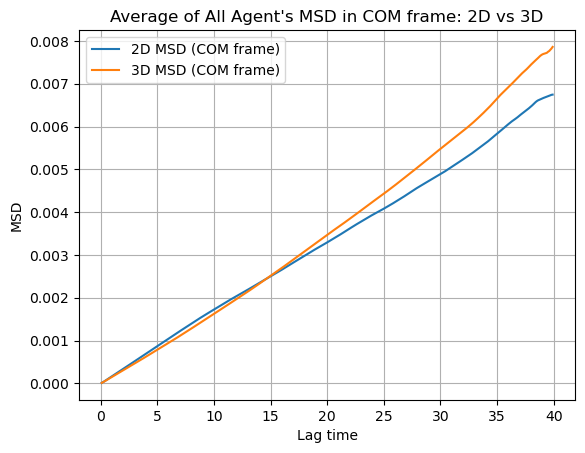

In [48]:
t2, msd2 = msd_com_frame(
    pos_2d,
    dt=dt,
    save_every=1,              # set to your save_every if not 1
    box_size=box_size,         # set to None if no periodic boundaries
    max_lag=None,              # or set e.g. 200
    average_over_agents=True, # single agent
    agent_idx=0
)

t3, msd3 = msd_com_frame(
    pos_3d,
    dt=dt,
    save_every=1,
    box_size=box_size,
    max_lag=None,
    average_over_agents=True,
    agent_idx=0
)

# --- 2) Plot overlay (raw MSD) ---
plt.figure()
plt.plot(t2, msd2, label="2D MSD (COM frame)")
plt.plot(t3, msd3, label="3D MSD (COM frame)")
plt.xlabel("Lag time")
plt.ylabel("MSD")
plt.title("Average of All Agent's MSD in COM frame: 2D vs 3D")
plt.legend()
plt.grid(True)
plt.show()

This plot is also measuring internal mixing (MSD in the flock’s center-of-mass frame), but over a longer range of lag times (up to ~40). At short lags the two curves are very close and even cross, which suggests that on very short time scales the internal motion in 2D and 3D is comparable. After roughly the mid-range (around lag ~15–20), the 3D curve (orange) rises above the 2D curve (blue) and the gap steadily widens, meaning that over longer time horizons agents in 3D end up wandering farther from their earlier positions within the flock than agents in 2D.

In other words, the plot suggests a time-scale effect wherein 2D may show stronger short-term, local rearrangements, but 3D accumulates more long-term internal displacement, showing higher diffusion after a long time. A likely interpretation is that 2D constraints create frequent small collisions and shuffling that don’t translate into sustained drift relative to the flock, while in 3D agents can take longer, smoother paths around the flock structure and gradually achieve larger net re-positioning over time.